In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import sklearn as sk
import sys
import torch
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # To encode the labels into numeric format
from simpletransformers.classification import ClassificationModel
import logging
import sklearn
import pickle

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

#import nltk
#nltk.download('punkt')  # Download tokenizer data

In [2]:
dataset = pd.read_csv("../datasets/cb_multi_labeled_unbalanced.csv", encoding='iso-8859-1')

In [3]:
dataset.head()

,text,label
0,@user nice new signage. Are you not concerned ...,hate
1,A woman who you fucked multiple times saying y...,hate
2,@user @user real talk do you have eyes or were...,hate
3,your girlfriend lookin at me like a groupie in...,hate
4,Hysterical woman like @user,hate


In [4]:
# Clean emojis from text
def strip_emoji(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

# Remove punctuations, stopwords, links, mentions, and new line characters
def strip_all_entities(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
        
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join(text.split())

# Remove URL shorteners
def remove_url_shorteners(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Ensure tweet is a string
    
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [5]:
dataset['text_clean'] = [clean_tweet(tweet) for tweet in dataset['text']]

In [6]:
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)

In [7]:
minimum_word_length = 3
dataset['processed_text'] = dataset['text'].apply(lambda x: [i for i in str(x).split() if not i in swords and (len(i) >= minimum_word_length)])

In [8]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
dataset['stemmed'] = dataset['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

In [9]:
dataset.drop(columns=['text', 'processed_text'], inplace=True)

In [10]:
dataset['stemmed'] = dataset['stemmed'].apply(lambda x: ' '.join([w for w in x]))

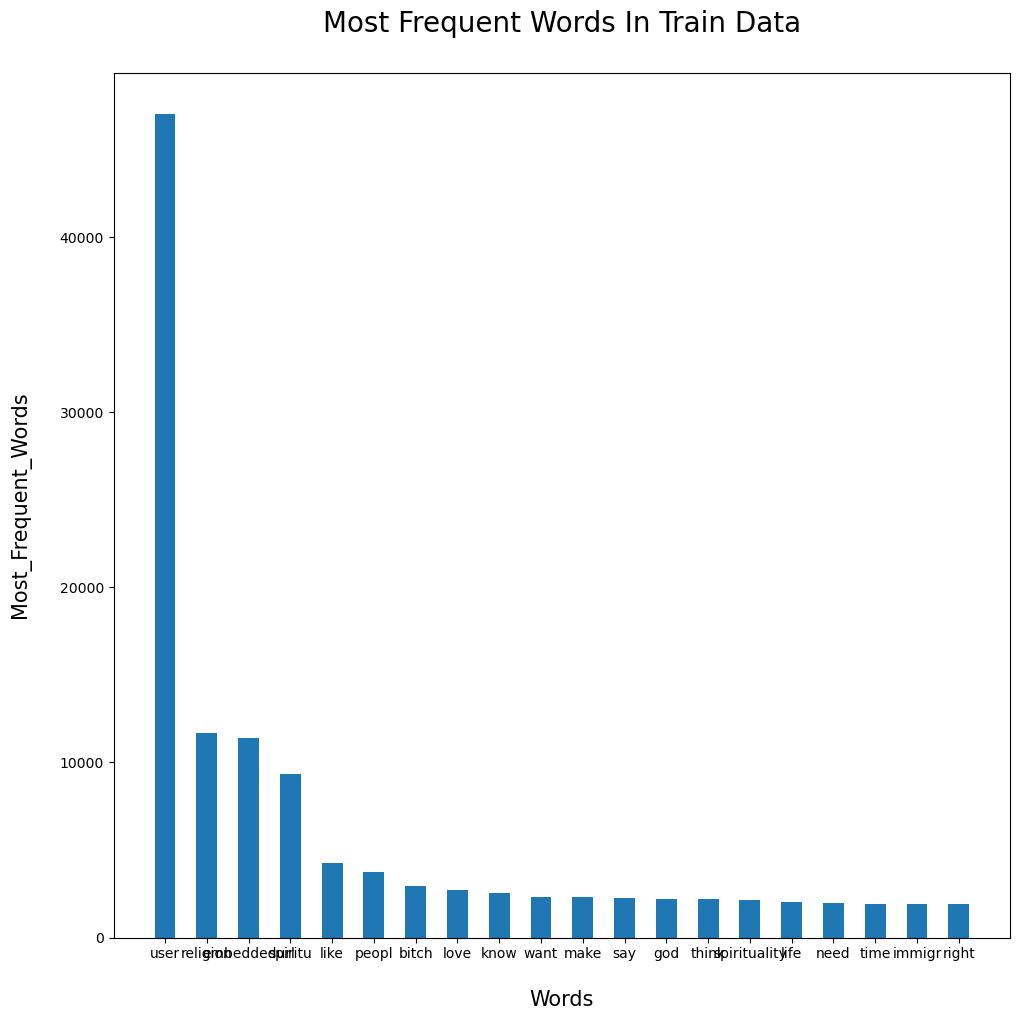

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(10,10))
count_vectorizer=CountVectorizer(stop_words="english")
word=count_vectorizer.fit_transform(dataset.stemmed)
sum_words=word.sum(axis=0)
most_freq_words=[(all_word,sum_words[0,i]) for all_word,i in count_vectorizer.vocabulary_.items()]
most_freq_words=sorted(most_freq_words,key=lambda x:x[1],reverse=True)

frequent_words=pd.DataFrame(most_freq_words,columns=["Words","Most_Frequent_Words"])

word_list = list(frequent_words.head(20).Words)
word_value_list = list(frequent_words.head(20).Most_Frequent_Words)

plt.bar(word_list, word_value_list,width=0.5)
plt.xlabel("\nWords",fontsize=15)
plt.ylabel("Most_Frequent_Words\n",fontsize=15)
plt.title("Most Frequent Words In Train Data\n",fontsize=20)
plt.tight_layout(pad=0)
plt.show()

In [12]:
dataset = dataset.rename(columns={"labels":"label", "stemmed":"text"}).reset_index(drop=True)

In [13]:
dataset.label.value_counts()

label
offensive    14100
hate         12914
religion     10478
spiritual     9442
emotion       5052
Name: count, dtype: int64

In [14]:
#dataset = dataset[dataset["cyberbullying_type"]!="other_cyberbullying"]

In [15]:
X = dataset.text
y = dataset.label

In [16]:
# Encode labels to numeric values (important for training)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # This will convert the labels into numeric values (e.g., 0, 1)

In [17]:
print(dataset['label'].unique())  # to see all unique labels

['hate' 'offensive' 'emotion' 'religion' 'spiritual']


In [18]:
from imblearn.over_sampling import RandomOverSampler

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.80)

#Apply oversampling to balance classes
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

# Create DataFrames for training and testing
train_dataset = pd.DataFrame({'text': X_train_os, 'label': y_train_os})
test_dataset = pd.DataFrame({'text': X_test, 'label': y_test})

In [19]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 11288],
       [    1, 11288],
       [    2, 11288],
       [    3, 11288],
       [    4, 11288]], dtype=int64)

In [20]:
#ROBERTA model
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'max_seq_length': 64,
    'num_train_epochs': 1,
    'train_batch_size': 16,  # Use a smaller batch size
    'fp16': False,  # Set to False if using CPU or don't have FP16 support
    'load_best_model_at_end': True,
    'push_to_hub': False,
}

In [21]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn
import pickle

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the XLNet base cased pre-trained model.
model = ClassificationModel('roberta', 'roberta-base', num_labels=5, args=train_args, use_cuda=False)

# Train the model, there is no development or validation set for this dataset 
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_dataset)

filename = 'best_model.pkl'
pickle.dump(model, open(filename, 'wb'))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/tokenizer_config.json HTTP/11" 200 0
C:\Users\USTB\anaconda3\Lib\site-packages\simpletransformers\classification\classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features

  0%|          | 0/112 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_64_5_2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/3528 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


In [27]:
import time
import psutil
import sklearn.metrics

# Function to get memory usage (in MB)
def get_memory_usage():
    mem = psutil.virtual_memory()
    return mem.used / (1024 ** 2)  # Returns memory usage in MB

# Function to measure CPU energy consumption (in watts) - Approximation
def estimate_energy_consumption(cpu_percent, duration_seconds):
    # Assume a rough average CPU power usage in watts (depends on hardware)
    average_cpu_wattage = 15  # in watts, this can vary greatly
    cpu_energy_kWh = (cpu_percent / 100) * average_cpu_wattage * duration_seconds / 3600000  # kWh
    return cpu_energy_kWh

# Start time tracking
start_time = time.time()

# Record initial RAM usage (before model evaluation)
initial_ram = get_memory_usage()

# Assume model.eval_model() is a function that returns a result and additional outputs
result, model_outputs, wrong_predictions = model.eval_model(test_dataset, acc=sklearn.metrics.accuracy_score)

# Calculate inference time
inference_time = time.time() - start_time

# Record RAM usage during model evaluation (final RAM usage)
final_ram = get_memory_usage()

# Calculate energy consumption (in kWh)
cpu_percent = psutil.cpu_percent(interval=1)  # Get current CPU usage percentage
energy_consumed = estimate_energy_consumption(cpu_percent, inference_time)

# Print the results
print(f"Accuracy: {result['acc']:.4f}")
print(f"Inference time: {inference_time:.4f} seconds")
print(f"RAM usage during evaluation: {final_ram - initial_ram:.2f} MB")  # RAM difference
print(f"CPU usage during evaluation: {cpu_percent:.2f}%")
print(f"Estimated energy consumption: {energy_consumed:.6f} kWh")


C:\Users\USTB\anaconda3\Lib\site-packages\simpletransformers\classification\classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_64_5_2


Running Evaluation:   0%|          | 0/104 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9431576215098637, 'acc': 0.9554722061934987, 'eval_loss': 0.16750254740831083}


Accuracy: 0.9555
Inference time: 494.2771 seconds
RAM usage during evaluation: 1288.55 MB
CPU usage during evaluation: 4.80%
Estimated energy consumption: 0.000099 kWh


In [23]:
result

{'mcc': 0.785768344491618,
 'acc': 0.8294392523364486,
 'eval_loss': 0.4455079197883606}

In [69]:
len(wrong_predictions)

199

In [72]:
to_predict = test_dataset["text"].tolist()  # Extract the text column
y_pred = model.predict(to_predict)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
60it [00:16,  3.54it/s]                        
100%|██████████| 300/300 [17:45<00:00,  3.55s/it]


In [73]:
test_dataset.sample(5)

,text,label
69359,@officialmoore7 game tonight?,2
27894,"thi serena joy creat rape cultur women, wrist ...",1
84025,#nowplay metro radio lord come @hermusicx chec...,2
69556,@johnnyrod @enotdolen @momma_swain1 @fivetimes...,3
57469,@bitcoinlfgo @manibheema1 ummm... where find m...,2


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\USTB\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\USTB\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\USTB\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:f

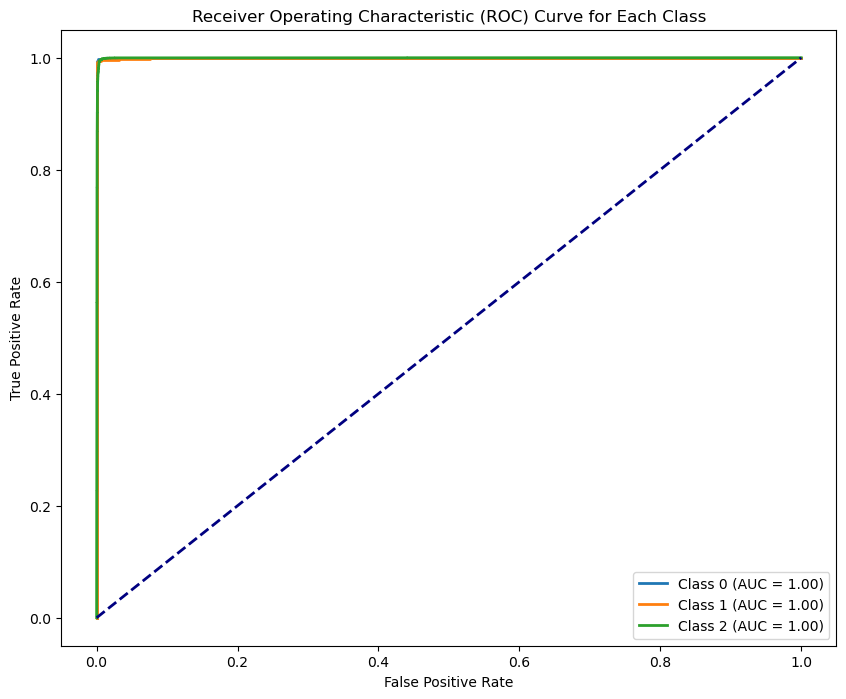

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Ensure that y_test is in integer format
y_true = [int(label) for label in y_test]

# Convert the model outputs to probabilities (assuming model outputs are softmax probabilities)
# model_outputs is a list of predicted probabilities for each class (e.g., for 3 classes)
y_pred_prob = np.array(model_outputs)

# Binarize the labels for multiclass
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Assuming 3 classes, adjust if needed
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001DD134F2BD0>


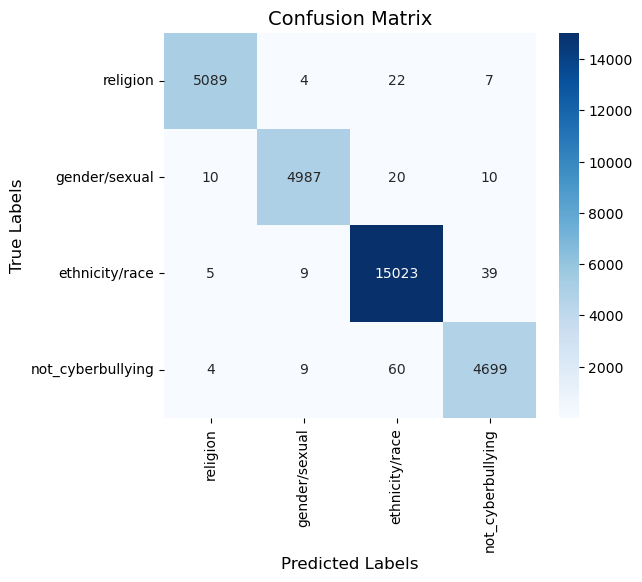

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels (y_true) and predicted labels (y_pred)
y_true = [int(label) for label in y_test]  # True labels
y_pred = [int(np.argmax(output)) for output in model_outputs]  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = ['religion', 'gender/sexual', 'ethnicity/race', 'not_cyberbullying']

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))  # Adjust the figure size if needed
cmap = sns.color_palette("Blues", as_cmap=True)  # Blue color palette

# Plot the confusion matrix using seaborn heatmap
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)

# Set labels and title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
plt.show()